# MIE 1624 Introduction to Data Science and Analytics – Winter 2018
## Assignment 1: Text Analytics and Sentiment Analysis
#### Kexin Zhang

This assignment performs text sentiment analysis to study the public opinion on Tweeter about the 2015 Canadian Federal Election and the correlation with the final election results. The assignment is divided into five sections: data cleaning, exploratory analysis, model preparation, model implementation, and discussion. 


<b> Note: </b> <br></br>
1. The three text files used (<i> unclassified_tweets.txt </i>, <i> classified_tweets.txt </i> and <i> stop_words.txt </i>) should be in the same directory as this IPython script.
2. <b> Section 4.4 </b> involves cross-validation for different classification methods and will take longer to run, so your patience is very much appriciated!

First, import all libraries needed:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import string
import re
import csv
import math

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

## 1. Data Cleaning

### 1.1 Import file data

In [2]:
# import unclassified_tweets.txt
unclassified_tweets = pd.read_csv('unclassified_tweets.txt', names=['unclassified_text'])
# import classified_tweets.txt, ignore first line containing headers
classified_tweets = pd.read_csv('classified_tweets.txt', sep = ',', names = ['class', 'id', 'date', 'query', 'user', 'text'],usecols = ['class', 'text'], skiprows = 1)

### 1.2 Remove all html tags and attributes

In [3]:
# strip html tags and attributes: <[^>]+>
unclassified_tweets['unclassified_text'] = unclassified_tweets['unclassified_text'].str.replace(r'<[^>]+>', '')
classified_tweets['text'] = classified_tweets['text'].str.replace('<[^>]+>', '')

In [4]:
classified_tweets.head()

,class,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### 1.3 Replace html character codes with ASCII equivalent

In [5]:
# create a dictionary to match html character codes to their ASCII equivalent
# dictionary key value pairs referenced from https://www.ascii.cl/htmlcodes.htm
conversion_dict = {'&lt;': '<', '&quot;': '\"','&gt;': '>', '&amp;': '&'}

# loop through all html characters and replace with corresponding ASCII values
for key, value in conversion_dict.items():
    unclassified_tweets['unclassified_text'] = unclassified_tweets['unclassified_text'].str.replace(key, conversion_dict[key])
    classified_tweets['text'] = classified_tweets['text'].str.replace(key, conversion_dict[key])

In [6]:
classified_tweets.head()

,class,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### 1.4 Remove URLs

In [7]:
unclassified_tweets['unclassified_text'] = unclassified_tweets['unclassified_text'].str.replace(r'http\S+', '')
classified_tweets['text'] = classified_tweets['text'].str.replace(r'http\S+', '')

In [8]:
classified_tweets.head()

,class,text
0,0,"@switchfoot - Awww, that's a bummer. You sho..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### 1.5 Change all letters to lower case

In [9]:
unclassified_tweets['unclassified_text'] = unclassified_tweets['unclassified_text'].str.lower()
classified_tweets['text'] = classified_tweets['text'].str.lower()

In [10]:
classified_tweets.head()

,class,text
0,0,"@switchfoot - awww, that's a bummer. you sho..."
1,0,is upset that he can't update his facebook by ...
2,0,@kenichan i dived many times for the ball. man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### 1.6 Remove all stop words

In [11]:
# import list of stop words provided
stop_words = pd.read_csv('stop_words.txt', delimiter='\n', names = ['words'])
stop_words_list = []
for index, row in stop_words.iterrows():
    if row['words'] not in list(string.ascii_lowercase):
        stop_words_list.append(row['words'])

# remove stop words
stop = r'\b(?:{})\b'.format('|'.join(stop_words_list))
unclassified_tweets['unclassified_text'] = unclassified_tweets['unclassified_text'].str.replace(stop, '')
classified_tweets['text'] = classified_tweets['text'].str.replace(stop, '')

# remove 't and 's 
classified_tweets['text'] = classified_tweets['text'].str.replace(r"'s", '')
classified_tweets['text'] = classified_tweets['text'].str.replace(r"'t", '')
unclassified_tweets['unclassified_text'] = unclassified_tweets['unclassified_text'].str.replace(r"'s", '')
unclassified_tweets['unclassified_text'] = unclassified_tweets['unclassified_text'].str.replace(r"'t", '')

In [12]:
classified_tweets.head()

,class,text
0,0,"@switchfoot - awww, a bummer. shoulda dav..."
1,0,upset update facebook texting ... cry ...
2,0,@kenichan i dived times ball. managed save...
3,0,body feels itchy fire
4,0,"@nationwideclass , behaving . i'm mad. i ..."


## 2. Exploratory Analysis

This section will determine the political parties that the tweets are associated with by searching relevent keywords. The results for unclassified tweets are presented in figures. Sentiment of classified tweets are also analyzed based on 0 (negative) and 4 (positive) attributes of each tweet.

### 2.1 Visualize Unclassified Data

#### 2.1.1 Determine political party of tweets
In the 2015 Canadian federal election, the five political parties involved are: <b> Liberal </b> (#liberal), <b> Conservative </b> (#convervative), <b> New Democratic </b> (#ndp), <b> Bloc Québécois </b> (#bloc) and <b> Green </b> (#greenparty). The classification of tweets will be based on these five political parties.

<b>Step 1</b>: Create keywords corresponding to each political party, these keywords are based on a quick search over twitter tags in unclassified_tweets.txt , note that these keywords can be expanded to improve the accuracy of results:

In [13]:
liberal_keywords = [r'liberal', r'liberals',r'justin', r'trudeau', r'lpc', r'ptlib']
conservative_keywords = [r'conservative', r'tory', r'stephen', r'harper', r'cpc', r'pttory']
ndp_keywords = [r'ndp', r'new democratic party', r'new democrat', r'thomas', r'mulcair', r'ptndp']
bloc_keywords = [r'bloc',r'quebecois', r'québécois', r'gilles', r'duceppe', r'bq', r'ptbloc']
green_keywords = [r'greenparty', r'elizabeth may', r'gpc', r'ptgreen', r'emayin']

<b>Step 2</b>: Search the number of occurances of the keywords in tweets and store in the corresponding parties. Note that a tweet is counted as associated with a political party as long as its content matches one or more of the corresponding keywords:

In [14]:
lib_identifier  = np.zeros(len(unclassified_tweets))
for i in range(0, len(liberal_keywords)):
    count_lib = unclassified_tweets['unclassified_text'].str.count(liberal_keywords[i]).values
    count_lib[np.isnan(count_lib)] = 0
    for ii in range(0, len(unclassified_tweets)):
        if count_lib[ii] != 0:
            lib_identifier[ii] = 1

cons_identifier  = np.zeros(len(unclassified_tweets))
for j in range(0, len(conservative_keywords)):
    count_cons = unclassified_tweets['unclassified_text'].str.count(conservative_keywords[j]).values
    count_cons[np.isnan(count_cons)] = 0
    for jj in range(0, len(unclassified_tweets)):
        if count_cons[jj] != 0:
            cons_identifier[jj] = 1

ndp_identifier  = np.zeros(len(unclassified_tweets))
for k in range(0, len(ndp_keywords)):
    count_ndp = unclassified_tweets['unclassified_text'].str.count(ndp_keywords[k]).values
    count_ndp[np.isnan(count_ndp)] = 0
    for kk in range(0, len(unclassified_tweets)):
        if count_ndp[kk] != 0:
            ndp_identifier[kk] = 1

bloc_identifier  = np.zeros(len(unclassified_tweets))
for m in range(0, len(bloc_keywords)):
    count_bloc = unclassified_tweets['unclassified_text'].str.count(bloc_keywords[m]).values
    count_bloc[np.isnan(count_bloc)] = 0
    for mm in range(0, len(unclassified_tweets)):
        if count_bloc[mm] != 0:
            bloc_identifier[mm] = 1

green_identifier  = np.zeros(len(unclassified_tweets))
for n in range(0, len(green_keywords)):
    count_green = unclassified_tweets['unclassified_text'].str.count(green_keywords[n]).values
    count_green[np.isnan(count_green)] = 0
    for nn in range(0, len(unclassified_tweets)):
        if count_green[nn] != 0:
            green_identifier[nn] = 1

party_num = np.array([sum(lib_identifier), sum(cons_identifier), sum(ndp_identifier), sum(bloc_identifier), sum(green_identifier)])

#### 2.1.2 Plot number of tweets associated with difference political parties

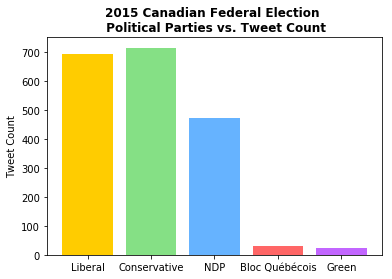

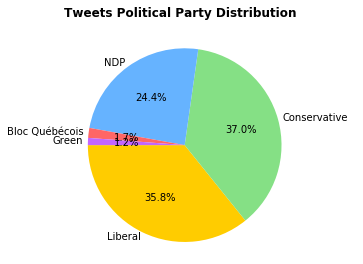

In [15]:
party_name = ['Liberal', 'Conservative', 'NDP', 'Bloc Québécois', 'Green']

# Plot bar chart to show quantities
plt.bar(np.arange(len(party_name)), party_num, color = ['#ffcc00', '#85e085','#66b3ff', '#ff6666','#c266ff'], align = 'center')
plt.xticks(np.arange(len(party_name)), party_name, fontsize = 10)
plt.ylabel('Tweet Count')
plt.title('2015 Canadian Federal Election \n Political Parties vs. Tweet Count', fontsize = 12, fontweight = 'bold')
plt.show()

# Plot pie chart to show percentage distribution
plt.pie(party_num, labels = party_name, colors = ['#ffcc00', '#85e085','#66b3ff', '#ff6666','#c266ff'], autopct='%1.1f%%', shadow=False, startangle=180, labeldistance=1.05)
plt.axis('equal')
plt.suptitle('Tweets Political Party Distribution', fontsize = 12, fontweight = 'bold')
plt.show() 

### 2.2 Visualize Classified Data

Identify the number of positive and negative tweets in classified data set:

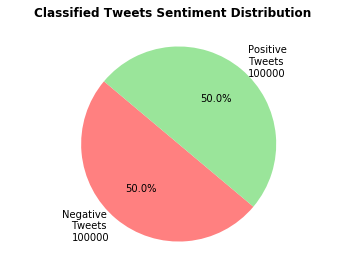

In [16]:
sentiment_freq = classified_tweets['class'].value_counts()  # count the number of occurances of 0 and 4
classified_pos = sentiment_freq[4]  # 4 represents positive sentiment
classified_neg = sentiment_freq[0]  # 0 represents negative sentiment
sentiment_label = ['Negative \nTweets \n%i'% classified_pos, 'Positive \nTweets \n%i'% classified_neg]

plt.pie([classified_pos, classified_neg], labels = sentiment_label, colors = ['#ff8080', '#9ae59a'], autopct='%1.1f%%', shadow=False, startangle=140)
plt.axis('equal')
plt.suptitle('Classified Tweets Sentiment Distribution', fontsize = 12, fontweight = 'bold')
plt.show() 

## 3. Model Preparation

### 3.1 Split Data into Testing and Training sets

In [17]:
# split data to 30% test data and 70% training data
x_train_raw, x_test_raw, y_train, y_test = train_test_split(classified_tweets['text'], classified_tweets['class'], test_size = 0.30)
y_train = y_train.astype('int')

### 3.2 Feature Exactraction

Feature extraction on classified data:

In [18]:
# Extract features using bag-of-words counting (referenced from Group 2 presentation material)
vectorize = CountVectorizer(analyzer='word', stop_words='english')
x_train = vectorize.fit_transform(x_train_raw)
# Test data is only transformed since it will only be used for checking accuracy
x_test = vectorize.transform(x_test_raw)

Feature extraction on unclassified data (convert to unicode first):

In [19]:
x_unclassified = vectorize.transform(unclassified_tweets['unclassified_text'].values.astype('U'))

## 4. Model Implementation

For high dimensional sparse data or large samples in general, <i><b> LogisticRegression </b></i> , <i><b> PassiveAggressiveClassifier </b></i> or <i><b> SGDClassifier </b></i> can be much faster to train for comparable predictive accuracy. In this section, all of the above classification methods are explored and their performances are compared.In addition, other classification methods such as <i><b> k-Nearest-Neighbors </b></i> and <i><b> Naive Bayes </b></i> algorithms will also be discussed. However, these two methods are associated with problems such as memory allocation when utilized on large data sets, as in the case of this assignment. Neverthless, method for tuning k-Nearest-Neighbors hyperparameters will still be introduced (code commented out) as a reference for small data sample problems. The method of cross-evaluation is also explored to get a better estimate of model accuracies and used for tuning.

### 4.1 Instantiate Model

Create an instance of different classifer to be used:

In [20]:
# Create an instance of Logistic Regression classifier 
model_lr = LogisticRegression()

# Create an instance of Passive Aggressive classifier
model_pa = PassiveAggressiveClassifier()

# Create an instance of SGDclassifier 
model_sgd = SGDClassifier()

# Create an instance of Naive Bayes classifier 
model_nb = GaussianNB()

# Create an instance k-nearest Neighbours classifier
model_knn = KNeighborsClassifier(n_neighbors=15)

### 4.2 Train Model

Train models LogisticRegression , PassiveAggressiveClassifier and SGDClassifier and compute test set predictions:

In [21]:
model_lr.fit(x_train, y_train)
y_pred_lr = model_lr.predict(x_test)

model_pa.fit(x_train, y_train)
y_pred_pa = model_pa.predict(x_test)

model_sgd.fit(x_train, y_train)
y_pred_sgd = model_sgd.predict(x_test)

When working with large data sets, k-Nearest-Neighbors and Naive Bayes are associated with memory issues and takes very long to train (despite using sparse matrices), therefore following lines are commented out:

In [22]:
# model_knn.fit(x_train, y_train)
# y_pred_knn = model_knn.predict(x_test) 

# model_nb.fit(x_train.toarray(), y_train)
# y_pred_nb = model_nb.predict(x_test.toarray())

### 4.3 Model Performances

Compare prediction with actual values and calculate accuracies of different classification methods:

In [23]:
print('Logistic Regression Accuracy:', metrics.accuracy_score(y_test, y_pred_lr)*100, "%")
print('Passive Agressive Accuracy:', metrics.accuracy_score(y_test, y_pred_pa)*100, "%")
print('SGD Accuracy:', metrics.accuracy_score(y_test, y_pred_sgd)*100, "%")

Logistic Regression Accuracy: 73.6316666667 %
Passive Agressive Accuracy: 68.28 %
SGD Accuracy: 73.4166666667 %


Due to reasons mentioned in Section 4.2, accuracies for k-Nearest-Neighbors and Naive Bayes classification methods are not calculated due to long training time and large memory required:

In [24]:
# print('KNN (K=5) Accuracy:', metrics.accuracy_score(y_test, y_pred_knn)*100, "%")
# print('Accuracy:', metrics.accuracy_score(y_test, y_pred_nb)*100, "%")

### 4.4 Cross-validation for parameter tuning and model selection

Although the previous train/test split method is fast and simple to examine the results of the testing process, it has a high variance estimate since changing which observations in the testing set can significantly change testing accuracy.

Alternatively, k-fold cross-validation method can be used to provide a more accurate estimate of out-of-sample accuracy and more efficiency in using data since every observation will be used for both training and testing. 

The general steps of implementing k-fold cross-validation include:
1. Split the dataset into k equal partitions (or "folds").
2. Use fold 1 as the testing set and the union of the other folds as the training set.
3. Calculate testing accuracy.
4. Repeat steps two and three k times, using a different fold as the testing set each time.
5. Use the average testing accuracy as the estimate of out-of-sample accuracy.

For example: <br></br>
Validate <b> Logistic Regression </b> classification method using 10-fold cross-validation gives:

In [25]:
scores_lr = cross_val_score(model_lr, vectorize.fit_transform(classified_tweets['text']), classified_tweets['class'], cv=10, scoring='accuracy')
print('Cross-validation Logistic Regression Score:', 100*scores_lr.mean(), "%")

Cross-validation Logistic Regression Score: 72.9595 %


Validate <b> Passive Agressive </b> classification method using 10-fold cross-validation gives:

In [26]:
scores_pa = cross_val_score(model_pa, vectorize.fit_transform(classified_tweets['text']), classified_tweets['class'], cv=10, scoring='accuracy')
print('Cross-validation Passive Agressive Classifier Score:', 100* scores_pa.mean(), "%")

Cross-validation Passive Agressive Classifier Score: 67.6415 %


Validate <b> SGD </b> classification method using 10-fold cross-validation gives:

In [27]:
scores_sgd = cross_val_score(model_sgd, vectorize.fit_transform(classified_tweets['text']), classified_tweets['class'], cv=10, scoring='accuracy')
print('Cross-validation SGD Classifier Score:', 100*scores_sgd.mean())

Cross-validation SGD Classifier Score: 72.913


#### 4.4.1 Tuning SGDClassifier parameters using cross-validation

SGDClassifier can be tuned by adjusting number of iterations (<b> n_iter </b> parameter default is 5). Although trying more n_iter values will yield better result, it can take a very long time run. Therefore, only values 2 to 15 are tried to find the best accuracy:

In [28]:
iter_range = list(range(2, 15))
sgd_scores = []
for iter in iter_range:
    sgd = SGDClassifier(n_iter = iter)
    scores = cross_val_score(sgd, vectorize.fit_transform(classified_tweets['text']), classified_tweets['class'], cv=10, scoring='accuracy')
    sgd_scores.append(scores.mean())
print('SGD Classifier Scores (with different n_iter):', sgd_scores)

SGD Classifier Scores (with different n_iter): [0.72675500000000004, 0.727935, 0.72857499999999997, 0.72885999999999995, 0.72975500000000004, 0.72894499999999995, 0.72959499999999999, 0.72966500000000001, 0.7294750000000001, 0.73007500000000003, 0.7297800000000001, 0.73009999999999997, 0.73003499999999999]


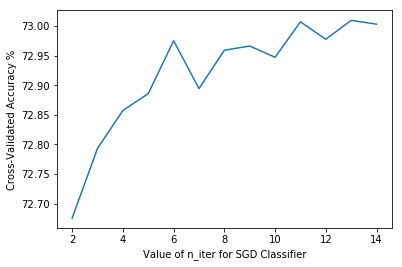

In [29]:
plt.plot(iter_range, [x * 100 for x in sgd_scores])
plt.xlabel('Value of n_iter for SGD Classifier')
plt.ylabel('Cross-Validated Accuracy %')
plt.show()

The number of iteration that performs the best in range(2, 15) is around 11 to 13 iterations (peak varies from each run, larger range and more time is needed to find the optimal parameter)

### 4.5 Use Model for Sentiment Analysis using Logistic Regression

Since logistic regression classification model yielded the highest accuracy in Section 4.3, logistic regression model will be used to predict unclassified data sentiment:

In [30]:
unclassified_predicted = model_lr.predict(x_unclassified)

# Find frequencies of 0s and 4s in predicted results
unclassified_freq = np.unique(unclassified_predicted, return_counts = True)

# Number of 0s represents the number of positive tweets, number of 4s represents
# the numer of negative tweets
unclassified_pos = unclassified_freq[1][1]
unclassified_neg = unclassified_freq[1][0]

Present unclassified tweets sentiment breakdown in pandas dataframe:

In [31]:
unclassified_table = pd.DataFrame(data = np.array([[unclassified_pos, unclassified_neg, unclassified_pos + unclassified_neg ]]), columns = ['Positive Sentiment', 'Negative Sentiment', 'Total'], index = ['Tweets Count'])
unclassified_table

,Positive Sentiment,Negative Sentiment,Total
Tweets Count,2159,867,3026


Present unclassified tweets sentiment breakdown in pie chart:

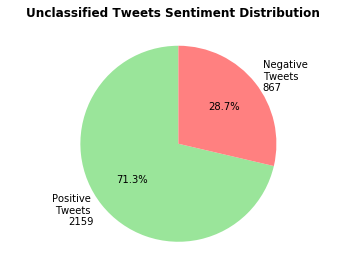

In [32]:
unclassified_sentiment_label = ['Positive \nTweets \n%i'% unclassified_pos, 'Negative \nTweets \n%i'% unclassified_neg]

plt.pie([unclassified_pos, unclassified_neg], labels = unclassified_sentiment_label, startangle= 90,colors = ['#9ae59a','#ff8080'], autopct='%1.1f%%', shadow=False)
plt.axis('equal')
plt.suptitle('Unclassified Tweets Sentiment Distribution', fontsize = 12, fontweight = 'bold')
plt.show() 

## 5. Discussion

### 5.1 Sentiment Breakdown of Difference Political Parties

Calulate the number of positive and negative tweets associated with each political party:

In [33]:
lib_pos = 0
lib_neg = 0
for a in range(0, len(unclassified_tweets)):
    if lib_identifier[a] == 1 and unclassified_predicted[a] == 4:
        lib_pos += 1
    if lib_identifier[a] == 1 and unclassified_predicted[a] == 0:
        lib_neg += 1
        
cons_pos = 0
cons_neg = 0
for b in range(0, len(unclassified_tweets)):
    if cons_identifier[b] == 1 and unclassified_predicted[b] == 4:
        cons_pos += 1
    if cons_identifier[b] == 1 and unclassified_predicted[b] == 0:
        cons_neg += 1

ndp_pos = 0
ndp_neg = 0
for c in range(0, len(unclassified_tweets)):
    if ndp_identifier[c] == 1 and unclassified_predicted[c] == 4:
        ndp_pos += 1
    if ndp_identifier[c] == 1 and unclassified_predicted[c] == 0:
        ndp_neg += 1

bloc_pos = 0
bloc_neg = 0
for d in range(0, len(unclassified_tweets)):
    if bloc_identifier[d] == 1 and unclassified_predicted[d] == 4:
        bloc_pos += 1

    if bloc_identifier[d] == 1 and unclassified_predicted[d] == 0:
        bloc_neg += 1

green_pos = 0
green_neg = 0
for e in range(0, len(unclassified_tweets)):
    if green_identifier[e] == 1 and unclassified_predicted[e] == 4:
        green_pos += 1

    if green_identifier[e] == 1 and unclassified_predicted[e] == 0:
        green_neg += 1

pos = [lib_pos, cons_pos, ndp_pos, bloc_pos, green_pos]
neg = [lib_neg, cons_neg, ndp_neg, bloc_neg, green_neg]

Present sentiment breakdown of different political parties in pandas dataframe:

In [34]:
pos_new = pos + [sum(pos)]
neg_new = neg + [sum(neg)]

unclassified_table = pd.DataFrame(data = [pos_new, neg_new], columns = party_name + ['Total'], index = ['Positive Tweets Count', 'Negative Tweets Count'])
unclassified_table

,Liberal,Conservative,NDP,Bloc Québécois,Green,Total
Positive Tweets Count,455,390,320,24,15,1204
Negative Tweets Count,236,324,151,8,8,727


Present sentiment breakdown of different political parties in bar chart:

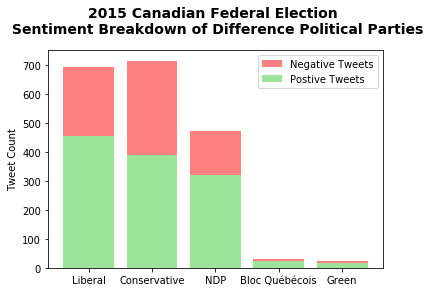

In [35]:
# Plotting the sentiment distribution for political party.
y_pos = np.arange(len(party_name))
p1 = plt.bar(y_pos, pos, color = '#9ae59a', align = 'center')
p2 = plt.bar(y_pos, neg, color = '#ff8080', align = 'center', bottom = pos)

plt.xticks(y_pos, party_name, fontsize = 10)
plt.ylabel('Tweet Count')
plt.title('2015 Canadian Federal Election \n Sentiment Breakdown of Difference Political Parties', fontsize = 14, fontweight = 'bold', y = 1.05)
plt.legend((p2[0], p1[0]), ('Negative Tweets', 'Postive Tweets'))
plt.show()

### 5.2 Sentiment Analysis and Election Results

According to Wikipedia documentation (https://en.wikipedia.org/wiki/Canadian_federal_election,_2015), the 2015 Canadian Federal Election vote results are: <br></br>
<b> Liberal </b>: 39.5% <br></br>
<b> Conservative </b>: 31.9% <br></br>
<b> NDP </b>: 19.7% <br></br>
<b> Bloc Québécois </b>: 4.7% <br></br>
<b> Green </b>: 3.4% <br></br>
Plot is created to study the relationship between tweets sentiment and the election results. The election votes are positively correlated with the number of positive tweets each party receives.

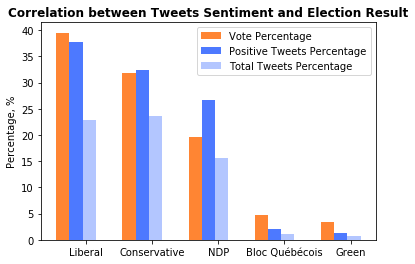

In [36]:
pos_percentage = [lib_pos/pos_new[5], cons_pos/pos_new[5], ndp_pos/pos_new[5], bloc_pos/pos_new[5], green_pos/pos_new[5]]
pos_percentage = [x * 100 for x in pos_percentage]

total_percentage = [party_num[0], party_num[1], party_num[2], party_num[3], party_num[4]]
total_percentage = [x * 100 / len(unclassified_tweets) for x in total_percentage]

vote_percentage = [39.5, 31.9, 19.7, 4.7, 3.4]

pt1 = plt.bar(y_pos, vote_percentage, 0.2, color='#ff8533')
pt2 = plt.bar(y_pos + 0.2, pos_percentage, 0.2, color='#4d79ff')
pt3 = plt.bar(y_pos + 0.4, total_percentage, 0.2, color='#b3c6ff')

plt.xticks(y_pos + 0.35, party_name, fontsize = 10)
plt.ylabel('Percentage, %')
plt.title('Correlation between Tweets Sentiment and Election Result', fontsize = 12, fontweight = 'bold')
plt.legend((pt1[0], pt2[0], pt3[0]), ('Vote Percentage', 'Positive Tweets Percentage', 'Total Tweets Percentage'))

plt.show()

As shown in the figure above, <b> vote percentage is positively correlated with positive tweets percentage </b>. It is interesting to note that even though the total number of tweets associated with conservative party is more than that of liberal party, conservative party has more negative tweets and less positive tweets compared to liberal party, which also explains the result that iberal won the federal election in 2015.